<a href="https://colab.research.google.com/github/Serbeld/ArtificialVisionForQualityControl/blob/master/yolo_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Modelos de Arquitecuras en YOLO (You Only Look Once)

In [0]:
#TINY YOLO

In [11]:
import numpy as np
import tensorflow as tf
import cv2
from google.colab import drive
drive.mount('/content/drive')
import sys
import pandas as pd
sys.path.append('/content/drive/My Drive/Yolo_Deep_Video/')
from keras.models import Model
import tensorflow as tf
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate

class CajaDetectada: #Clase Caja---Este es el formato de las salidas de Yolo
    def __init__(self, xmin, ymin, xmax, ymax, c = None, clases = None):#Inicializacion de Caja
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.clases = clases

        self.etiqueta = -1
        self.puntuacion = -1

    def obtener_etiqueta(self):#Obtencion de la etiqueta con mayor probabilidad
        if self.etiqueta == -1:
            self.etiqueta = np.argmax(self.clases)
        
        return self.etiqueta
    
    def obtener_puntuacion(self):#Obtencion de la puntuación o probabilidad asignada a la etiqueta elegida
        if self.puntuacion == -1:
            self.puntuacion = self.clases[self.obtener_etiqueta()]
            
        return self.puntuacion


def iou_cajas(caja1, caja2):#Funcion de calculo de la Intersección sobre la Union de las Cajas o IOU
    interseccion_ancho = intervalo_superposicion([caja1.xmin, caja1.xmax], [caja2.xmin, caja2.xmax])
    interseccion_alto = intervalo_superposicion([caja1.ymin, caja1.ymax], [caja2.ymin, caja2.ymax])  
    
    interseccion = interseccion_ancho * interseccion_alto

    ancho1, alto1 = caja1.xmax-caja1.xmin, caja1.ymax-caja1.ymin
    ancho2, alto2 = caja2.xmax-caja2.xmin, caja2.ymax-caja2.ymin
    
    union = ancho1*alto1 + ancho2*alto2 - interseccion
    
    return float(interseccion) / union

def dibujar_deteccion(imagen, cajas, etiquetas):#Funcion de dibujado de Cajas de salida de Yolo
    imagen_alto, imagen_ancho, _ = imagen.shape
    for caja in cajas:
        xmin = int(caja.xmin*imagen_ancho)#Obtencion de la xminima normalizada con respectom al ancho de imagen
        ymin = int(caja.ymin*imagen_alto)#Obtencion de la yminima normalizada con respectom al alto de imagen
        xmax = int(caja.xmax*imagen_ancho)#Obtencion de la xmaxima normalizada con respectom al ancho de imagen
        ymax = int(caja.ymax*imagen_alto)#Obtencion de la yminima normalizada con respectom al alto de imagen
        cv2.rectangle(imagen, (xmin,ymin), (xmax,ymax), (210,120,30), 2)#Dibujado de rectangulo de deteccion
        cv2.putText(imagen, (etiquetas[caja.obtener_etiqueta()] + str(round((caja.obtener_puntuacion()*100),2))), (xmin, ymin - 13),
        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * imagen_alto, (255,0,0), 2)#Escritura de etiqueta y confianza de deteccion
        
    return imagen
        
def decodificacion_salida(salidared, tamano_base, numero_clases, umbral_objeto=0.6, umbral_supresionomaxima=0.6):#Decodificacion de salidas de Yolo a formato Caja
    
    global IOU
    
    rejilla_alto, rejilla_ancho, numero_cajas = salidared.shape[:3]#Ancho y alto de rejilla con respecto a imagen

    cajas = []#definicion de lista de cajas
    Iou_scores = []

    # decodificacion de la salida
    salidared[..., 4]  = _sigmoidal(salidared[..., 4])# Aplicacion de activacion sigmoidal al subconjunto de confianzas de la salida de yolo
    salidared[..., 5:] = salidared[..., 4][..., np.newaxis] * _softmax(salidared[..., 5:])
    salidared[..., 5:] *= salidared[..., 5:] > umbral_objeto#Aplicacion de Softmax al conjunto de clases y umbralización
    #segun el umbral de objeto predefinido por nosotros

    #NOTA: Hasta el cuarto elemento se situan X, Y, ancho y alto de caja, a partir del cuarto elemento se situan la confianza de caja y las probabilidades por clase

    for fila in range(rejilla_alto):#Bucle de recorrido de rejilla y cajas para obtener las cajas resultantes con el umbral de objetos aplicado
        for columna in range(rejilla_ancho):
            for b in range(numero_cajas):

                clases = salidared[fila,columna,b,5:]#Probabilidades por clase
                
                if np.sum(clases) > 0:#Condicion de que haya clases

                    x, y, w, h = salidared[fila,columna,b,:4]# Obtencion de X,Y,Ancho y Alto de cajas

                    x = (columna + _sigmoidal(x)) / rejilla_ancho # Obtencion de coordenada X de la esquina superior de la caja a partir de las salidas normalizadas
                    y = (fila + _sigmoidal(y)) / rejilla_alto  # Obtencion de coordenada Y de la esquina superior de la caja a partir de las salidas normalizadas
                    w = tamano_base[2 * b + 0] * np.exp(w) / rejilla_ancho # Obtención del ancho desnormalizado de la caja propuesta a partir de los posibles anchos y la exponencial del ancho normalizado
                    h = tamano_base[2 * b + 1] * np.exp(h) / rejilla_alto # Obtención del alto desnormalizado de la caja propuesta a partir de los posibles altos y la exponencial del alto normalizado
                    confianza = salidared[fila,columna,b,4]#Obtención de la confianza de las diferentes cajas propuestas
                    
                    caja = CajaDetectada(x-w/2, y-h/2, x+w/2, y+h/2, confianza, clases)#Obtencion de la caja propuesta dentro de la clase caja

                    cajas.append(caja)

    # Bucle de recorrido de cajas para obtener las cajas resultantes con el umbral de supresion no maximo de cajas
    for c in range(numero_clases):
        indices_ordenados = list(reversed(np.argsort([caja.clases[c] for caja in cajas])))

        for i in range(len(indices_ordenados)):
            index_i = indices_ordenados[i]
            
            if cajas[index_i].clases[c] == 0: 
                continue
            else:
                for j in range(i+1, len(indices_ordenados)):
                    index_j = indices_ordenados[j]
                    
                    if iou_cajas(cajas[index_i], cajas[index_j]) >= umbral_supresionomaxima:#Aplicacion de umbral de IOU para encontrar las mejores cajas candidatas posibles
                    
                        Iou_scores.append(iou_cajas(cajas[index_i], cajas[index_j]))
                        cajas[index_j].clases[c] = 0

    cajas = [caja for caja in cajas if caja.obtener_puntuacion() > umbral_objeto]#Eliminar aquellas cajas cuyo umbral no supere el umbral del objeto
    
    #print("IOU Scores: "+str(promlista(Iou_scores)))

    IOU = promlista(Iou_scores)

    return cajas


def promlista(lista):
  
  global xaa

  sum = 0.0
  
  try: 
    for i in range(0,len(lista)):
      sum = sum + lista[i]
      xaa = sum/len(lista)

  except:
    xaa = 0
  return(xaa)

        
def intervalo_superposicion(intervalo_a, intervalo_b):#Funcion del calculo del intervalo de superposicion de cajas
    x1, x2 = intervalo_a
    x3, x4 = intervalo_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoidal(x):#Funcion de aplicacion de activacion sigmoidal
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):#Funcion de aplicacion de activacion softmax
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from keras.models import Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
import numpy as np
import os
import cv2
from keras.layers.merge import concatenate
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Yolo_Deep_Video/')

ruta_yolo_backend   = '/content/drive/My Drive/Yolo_Deep_Video/tiny_yolo_backend.h5'   # nombre del extractor de características a utilizar



class ExtractorCaracteristicasBase(object):# Clase Base para los posibles extractores de características

    def __init__(self, tamano_entrada):
        raise NotImplementedError("error message")

    def normalizacion(self, imagen):
        raise NotImplementedError("error message")

    def obtener_tamano_salida(self):
        return self.extractor_caracteristicas.get_output_shape_at(-1)[1:3]

    def extraer(self, imagen_entrada):
        return self.extractor_caracteristicas(imagen_entrada)

class FullYoloFeature(ExtractorCaracteristicasBase):#Extractor de características original de Yolo
    
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))

        # Layer 1
        x = Conv2D(16, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
        x = BatchNormalization(name='norm_1')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 2 - 5
        for i in range(0,4):
            x = Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', name='conv_' + str(i+2), use_bias=False)(x)
            x = BatchNormalization(name='norm_' + str(i+2))(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 6
        x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
        x = BatchNormalization(name='norm_6')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(x)

        # Layer 7 - 8
        for i in range(0,2):
            x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_' + str(i+7), use_bias=False)(x)
            x = BatchNormalization(name='norm_' + str(i+7))(x)
            x = LeakyReLU(alpha=0.1)(x)

        self.extractor_caracteristicas = Model(input_image, x)  
        self.extractor_caracteristicas.load_weights(ruta_yolo_backend)

    def normalize(self, image):
        return image / 255.

    def normalizacion(self, imagen):#Normalizacion aplicada a las imagenes de entrada
        return imagen / 255.



class YOLO(object):#Inicializacion de la clase Yolo, que contiene el procesado previo y posterior de Yolo
    def __init__(self, backend,tamano_entrada, etiquetas, max_cajas_por_imagen,tamanos_base ):#Funcion de inicializacion de Yolo

        #Inicializacion de variables
        self.tamano_entrada = tamano_entrada
        self.etiquetas   = list(etiquetas)
        self.numero_clases = len(self.etiquetas)
        self.numero_cajas   = len(tamanos_base)//2
        self.class_wt = np.ones(self.numero_clases, dtype='float32')
        self.tamanos_base  = tamanos_base
        self.max_cajas_por_imagen =max_cajas_por_imagen

        #Creacion del Modelo

        #1-Creacion de extractor de caracteristicas
        imagen_entrada     = Input(shape=(self.tamano_entrada, self.tamano_entrada, 3))
        self.cajas_buenas = Input(shape=(1, 1, 1, max_cajas_por_imagen , 4))  

        self.extractor_caracteristicas = FullYoloFeature(self.tamano_entrada)

        print(self.extractor_caracteristicas.obtener_tamano_salida())    
        self.rejilla_alto, self.rejilla_ancho = self.extractor_caracteristicas.obtener_tamano_salida()        
        caracteristicas = self.extractor_caracteristicas.extraer(imagen_entrada)            

        #2-Creacion de capas de salida adaptadas al numero de cajas,clases
        salida = Conv2D(self.numero_cajas * (4 + 1 + self.numero_clases), (1,1), strides=(1,1), padding='same', name='DetectionLayer',kernel_initializer='lecun_normal')(caracteristicas)
        salida = Reshape((self.rejilla_alto, self.rejilla_ancho, self.numero_cajas, 4 + 1 + self.numero_clases))(salida)
        salida = Lambda(lambda args: args[0])([salida, self.cajas_buenas])

        self.model = Model([imagen_entrada, self.cajas_buenas], salida)
        
        #Inicializacion de pesos de las capas de salida
        capa = self.model.layers[-4]
        pesos = capa.get_weights()

        nuevo_kernel = np.random.normal(size=pesos[0].shape)/(self.rejilla_alto*self.rejilla_ancho)
        nuevo_bias   = np.random.normal(size=pesos[1].shape)/(self.rejilla_alto*self.rejilla_ancho)

        capa.set_weights([nuevo_kernel, nuevo_bias])

        self.model.summary()


    def cargar_pesos(self, weight_path):# Funcion de cargado de pesos preentrenados
        self.model.load_weights(weight_path)


    def predecir(self, imagen,umbral_objeto,umbral_supresionomaxima):#Funcion de prediccion
        alto_imagen, ancho_imagen, _ = imagen.shape
        imagen = cv2.resize(imagen, (self.tamano_entrada, self.tamano_entrada))#Cambio de tamaño de la imagen de entrada al tamaño de deteccion de Yolo
        imagen = self.extractor_caracteristicas.normalizacion(imagen)#Normalizacion de la imagen de entrada

        imagen_entrada = imagen[:,:,::-1]
        imagen_entrada = np.expand_dims(imagen_entrada, 0)
        dummy_array = np.zeros((1,1,1,1,self.max_cajas_por_imagen,4))

        salidared = self.model.predict([imagen_entrada, dummy_array])[0]#prediccion del modelo extractor de caracteristicas
        cajas  = decodificacion_salida(salidared, self.tamanos_base, self.numero_clases,umbral_objeto,umbral_supresionomaxima)#Decodificacion de la salida Yolo en formato caja

        return cajas,salidared



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(13, 13)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 13, 13, 1024) 15739760    input_12[0][0]                   
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 13, 13, 40)   41000       model_7[1][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 13, 13, 5, 8) 

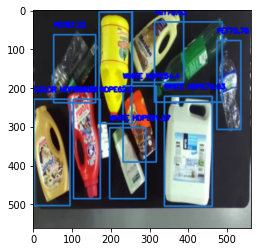

Frame actual=3000
Frames por segundo=39.662449172576835
IOU Scores: 0.7071574581968337


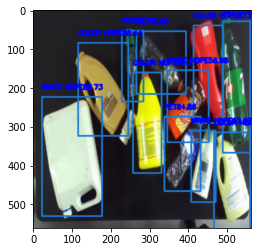

Frame actual=6000
Frames por segundo=40.24432695905816
IOU Scores: 0.6931928460738562


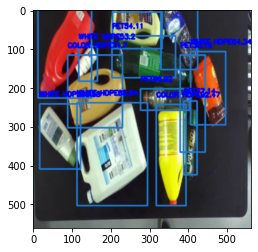

El IOU promedio del modelo fue de :0.69
Los FPS promedio del modelo fue de: 39.9


In [13]:

import cv2 # importacion de opencv
import numpy as np #importacion de numpy
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Yolo_Deep_Video/')
import json#importacion de libreria de apertura de json
import time#importacion de libreria de medicion de tiempos
import matplotlib.pyplot as plt


ruta_configuracion = '/content/drive/My Drive/Yolo_Deep_Video/configuracion.json' #ruta a archivo de configuracion
ruta_pesos = '/content/drive/My Drive/Yolo_Deep_Video/Yolo_best_weights0.h5'#ruta a red yolo ya entrenada

with open(ruta_configuracion) as buffer_configuracion:#Cargado de fichero de configuracion
    configuracion = json.load(buffer_configuracion)


yolo = YOLO(backend             = configuracion['model']['backend'],
            tamano_entrada         = configuracion['model']['tamano_entrada'],
            etiquetas             = configuracion['model']['etiquetas'],
            max_cajas_por_imagen   = configuracion['model']['max_cajas_por_imagen'],
            tamanos_base            = configuracion['model']['tamanos_base'])#Creacion del modelo Yolo segun el fichero de configuracion


yolo.cargar_pesos(ruta_pesos)#Cargado de pesos de red Yolo previamente entrenada


capturador_video=cv2.VideoCapture('/content/drive/My Drive/Yolo_Deep_Video/Testing.mp4')#apertura de video a procesar
fourcc = cv2.VideoWriter_fourcc(*'mp4v')#configuracion de codec de video
videofps=capturador_video.get(cv2.CAP_PROP_FPS)
ret, frame = capturador_video.read()#Lectura del primer frame
video_salida = cv2.VideoWriter('/content/drive/My Drive/Yolo_Deep_Video/salidaTinyYOLO.mp4',fourcc, videofps, (frame.shape[0], frame.shape[0]))# Creacion de video de salida procesado con Yolo
numero_frames = int(capturador_video.get(cv2.CAP_PROP_FRAME_COUNT))
print('El numero de frames del video es=' + str(numero_frames))
#cv2.namedWindow('test', cv2.WINDOW_NORMAL)#creacion de ventana de reproduccion

contador = 0

IOU_TOTAL = 0
FPS_TOTAL = 0

frame_actual = 0

while (frame_actual<=numero_frames-5):#bucle de lectura

    ret, frame = capturador_video.read()#lectura de frames

    frame = cv2.resize(frame,(375,375))
    frame=frame[:,int(frame.shape[1]/2)-int(frame.shape[0]/2):int(frame.shape[1]/2)+int(frame.shape[0]/2),:]
    test=frame.copy()

    #cv2.imshow('test',test)#visualizacion de frames
    #cv2.waitKey(1)#retardo de 1ms necesario para la reproduccion de opencv
    if(frame_actual%15==0):

      start = time.time()#comienzo de medicion de tiempo
      [cajas,caracteristicas] = yolo.predecir(test,0.3,0.3)#prediccion de yolo
      end = time.time()#finalizacion de medicion de tiempo
      dif = ((end - start))#diferencia de tiempos
      fps=1/dif#conversion a frames por segundo

      imageaux = dibujar_deteccion(test, cajas, configuracion['model']['etiquetas'])#dibujado de detecciones de yolo en la imagen
      
      for i in range(0,30):
        video_salida.write(test)#grabacion de frames en el video de salida
      
      contador = contador + 1
      IOU_TOTAL = IOU_TOTAL + IOU
      FPS_TOTAL = FPS_TOTAL + fps

      if(frame_actual%1000==0):
        print('Frame actual='+ str(frame_actual))
        print('Frames por segundo='+ str(fps))
        print("IOU Scores: "+str(IOU))
        plt.imshow(cv2.resize(test[:,:,::-1], (int(test.shape[0]*1.5), int(test.shape[1]*1.5))))
        plt.show()

    frame_actual=frame_actual+1

global modelos_final
global iou_final
global fps_final

modelos_final = ['Tiny Yolo']
iou_final = [round((IOU_TOTAL/contador),2)]
fps_final = [round((FPS_TOTAL/contador),1)]

print("El IOU promedio del modelo fue de :"+ str(iou_final[-1]))
print("Los FPS promedio del modelo fue de: "+ str(fps_final[-1]))

video_salida.release() #finalizacion de video de salida


In [0]:
'''modelos_final = ['Tiny Yolo']
iou_final = [round((IOU_TOTAL/contador),2)]
fps_final = [round((FPS_TOTAL/contador),1)]'''

# Se organiza la Data MODELO IOU FPS 
data = {'Modelo': modelos_final,'IOU': iou_final,'FPS':fps_final}
            
df = pd.DataFrame(data, columns = ['Modelo','IOU','FPS'])
        
# Se guarda la data en un archivo excel
df.to_excel('/content/drive/My Drive/Yolo_Deep_Video/Metrics.xlsx', sheet_name=('Metrics'))